In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import pyro
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats 

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In [40]:
from pyro.infer import MCMC, NUTS

In [41]:
business_df = pd.read_csv('../datasets/Transformed_Dataset.csv')

In [42]:
business_df.shape

(300153, 26)

have histograms based if it is economy class


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

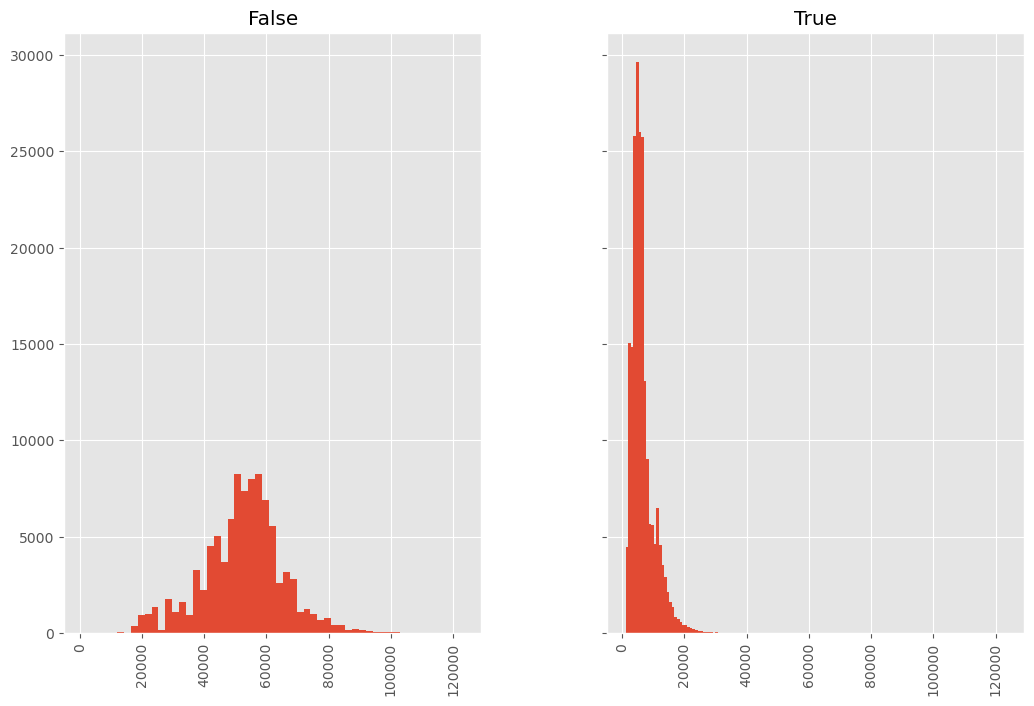

In [43]:
print('have histograms based if it is economy class')

business_df.hist('price', bins=50, by=business_df['Economy'], sharey=True, sharex=True)

array([[<Axes: title={'center': 'price'}>]], dtype=object)

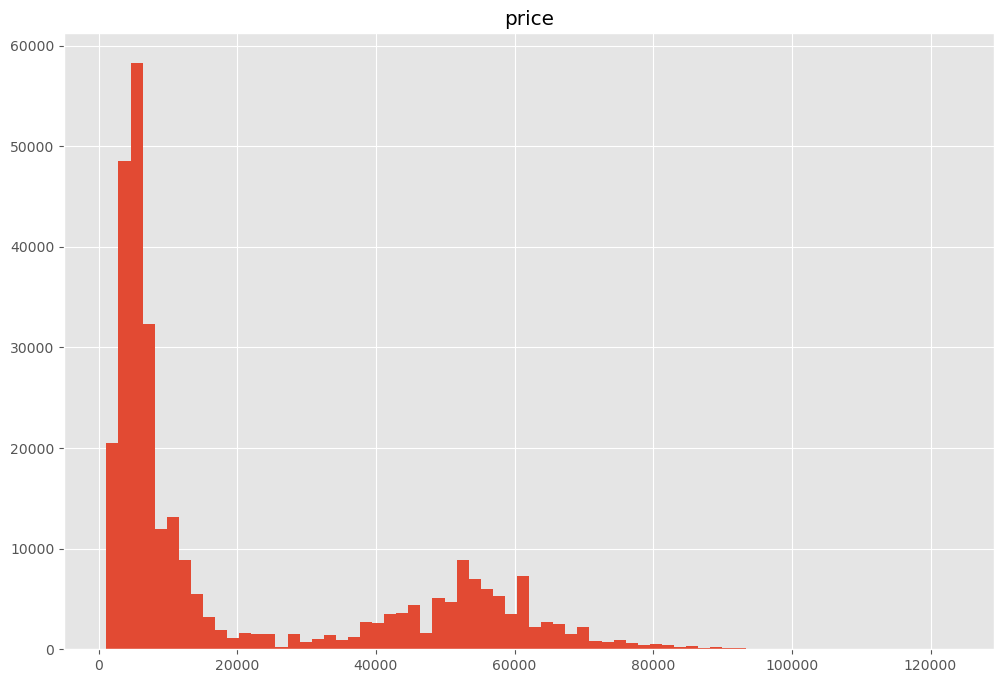

In [44]:
business_df.hist('price', bins=70)

In [45]:
business_df = business_df.sample(frac=.2)

In [48]:
train_x, test_x, train_y,test_y = train_test_split(business_df.drop('price',axis=1), business_df['price'], test_size=0.33, random_state=488)

x_simple_train_clean = torch.tensor(train_x.to_numpy(dtype=np.float32)) #business_df['Economy']
y_simple_train_clean = torch.tensor(train_y.to_numpy(dtype=np.float32))

x_simple_test_clean = torch.tensor(test_x.to_numpy(dtype=np.float32)) #business_df['Economy']
y_simple_test_clean = torch.tensor(test_y.to_numpy(dtype=np.float32))

buss_train= train_x['Economy']
buss_test= test_x['Economy']

train_x = train_x.drop('Economy', axis=1)
test_x = test_x.drop('Economy', axis=1)

x_train_clean = torch.tensor(train_x.to_numpy(dtype=np.float32)) #business_df['Economy']
y_train_clean = torch.tensor(train_y.to_numpy(dtype=np.float32))

x_test_clean = torch.tensor(test_x.to_numpy(dtype=np.float32)) #business_df['Economy']
y_test_clean = torch.tensor(test_y.to_numpy(dtype=np.float32))

In [49]:
#buss = buss.astype(dtype= np.int_)
buss_train = torch.tensor(buss_train.to_numpy(dtype=np.int_))
buss_test = torch.tensor(buss_test.to_numpy(dtype=np.int_))

In [12]:
x_train_clean.count_nonzero(), len(x_train_clean)

(tensor(198643), 20110)

In [13]:
x_train_clean

tensor([[1.4170e+01, 4.9000e+01, 3.5710e+03,  ..., 0.0000e+00, 1.0000e+00,
         1.2990e+03],
        [2.1700e+00, 2.2000e+01, 3.0440e+03,  ..., 0.0000e+00, 0.0000e+00,
         5.2700e+02],
        [2.6000e+01, 2.5000e+01, 5.5377e+04,  ..., 0.0000e+00, 0.0000e+00,
         1.4310e+03],
        ...,
        [1.5250e+01, 4.8000e+01, 4.1220e+03,  ..., 0.0000e+00, 0.0000e+00,
         1.3290e+03],
        [1.5000e+00, 9.0000e+00, 5.0310e+03,  ..., 0.0000e+00, 0.0000e+00,
         1.3460e+03],
        [2.7500e+00, 1.1000e+01, 7.3520e+03,  ..., 1.0000e+00, 0.0000e+00,
         1.4500e+03]])

In [ ]:
beta[buss].shape

In [ ]:
beta = torch.transpose(beta[buss],0,1)

In [ ]:
beta.shape

## Model taking all features into account 

In [51]:
def full_simple_model(x=None, obs=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([20000.])
    mu_scale = torch.tensor([2000.])
    sigma_scale = torch.tensor([100.])

    #if the class is stil in the dataset and not taken separately
    beta = pyro.sample('beta', pyro.distributions.Normal(torch.zeros(25),torch.ones(25)).to_event())
    alpha = pyro.sample('alpha', pyro.distributions.Normal(mu_loc,mu_scale))
    sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))

    with pyro.plate('data', len(obs)):
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        price = pyro.sample('price', pyro.distributions.Normal(alpha + x.matmul(beta),sigma), obs=obs)
    
    return price

In [66]:
def full_model(x=None, obs=None,buss=None):
    # priors for components
    
    mu_loc = torch.tensor([50000. , 5000.])
    mu_scale = torch.tensor([500., 500.])
    sigma_scale = torch.tensor([100.,100.])
    buss = buss
    
    beta = pyro.sample('beta', pyro.distributions.Normal(torch.zeros(24),torch.ones(24)).to_event())
    with pyro.plate('components', 2):
        alpha = pyro.sample('alpha', pyro.distributions.Normal(mu_loc,mu_scale))
        sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
    
    with pyro.plate('data', len(obs)):
        price = pyro.sample('price', pyro.distributions.Normal(alpha[buss] + x.matmul(beta),sigma[buss]), obs=obs)
    
    return price

In [64]:
def full_model2(x=None, obs=None,buss=None):
    # priors for components
    #pi = pyro.sample('pi', pyro.distributions.Beta(2.,2.))
    mu_loc = torch.tensor([5000. , 50000.])
    mu_scale = torch.tensor([500., 5000.])
    sigma_scale = torch.tensor([100.,100.])
    print(1)
    beta = pyro.sample('beta', pyro.distributions.Normal(torch.zeros((2,x.shape[1])),torch.ones((2,x.shape[1]))).to_event())
    alpha = pyro.sample('alpha', pyro.distributions.Normal(mu_loc,mu_scale))
    sigma = pyro.sample('sigma', pyro.distributions.HalfCauchy(sigma_scale))#torch.ones(1)))
    print(2)
    beta = torch.t(beta[buss])
    buss = buss
    print(3)
    with pyro.plate('data', len(obs)):
        print(4)
        #buss = pyro.sample('busi', pyro.distributions.Bernoulli(pi), infer={"enumerate":"parallel"}).long()
        price = pyro.sample('price', pyro.distributions.Normal(alpha[buss] + x.matmul(beta),sigma[buss]), obs=obs)
        print(5)
    
    return price

In [67]:
# Run inference in Pyro
nuts_kernel = NUTS(full_model)
mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=200, num_chains=1)
mcmc.run(x_train_clean,y_train_clean,buss_train)

# Show summary of inference results
mcmc.summary()

Sample: 100%|█████████████████████████████████████████| 600/600 [17:22,  1.74s/it, step size=1.45e-02, acc. prob=0.943]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]  53588.09    207.73  53596.99  53257.68  53916.27    466.57      1.00
  alpha[1]   7996.48    129.23   7995.79   7811.23   8227.64    434.73      1.00
   beta[0]      8.96      0.96      8.93      7.49     10.56    528.70      1.00
   beta[1]    -25.76      0.87    -25.77    -27.16    -24.37    392.51      1.00
   beta[2]     -5.00      0.81     -4.96     -6.33     -3.66    439.77      1.00
   beta[3]     -4.01      0.77     -4.01     -5.03     -2.74    303.49      1.00
   beta[4]     -0.06      0.93     -0.05     -1.81      1.28    298.07      1.00
   beta[5]     -0.02      1.06     -0.06     -1.85      1.61    469.87      1.00
   beta[6]     -0.07      0.95     -0.08     -1.72      1.36    439.78      1.00
   beta[7]      0.01      0.92      0.01     -1.38      1.64    907.01      1.00
   beta[8]      0.14      1.02      0.12     -1.58      1.76    475.18      1.00
   beta[9]     -0.15      1

In [68]:
train_x.columns

Index(['duration', 'days_left', 'source_size', 'destination_size',
       'departure_time_Afternoon', 'departure_time_Early_Morning',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night',
       'arrival_time_Afternoon', 'arrival_time_Early_Morning',
       'arrival_time_Evening', 'arrival_time_Late_Night',
       'arrival_time_Morning', 'arrival_time_Night', 'stops_num',
       'airline_AirAsia', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'flight_num'],
      dtype='object')

In [34]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [35]:
palette = itertools.cycle(sns.color_palette())

C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

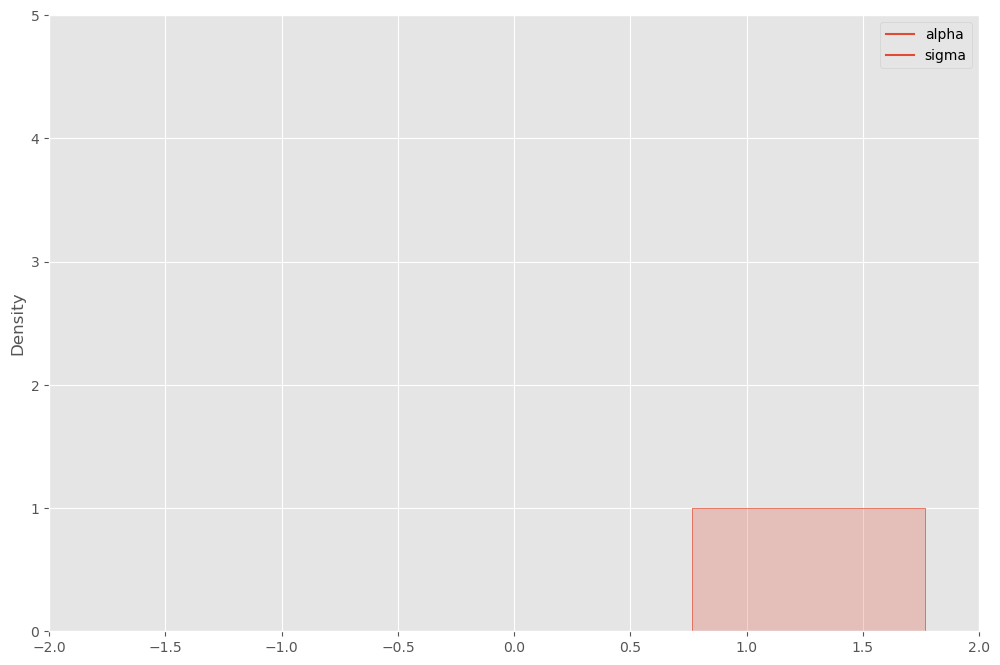

In [36]:
posterior_samples = mcmc.get_samples()

sns.kdeplot(posterior_samples["alpha"])
sns.kdeplot(posterior_samples["sigma"])

# Alternate plotting due to deprecated distplot-function
sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,5])
plt.show()

C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

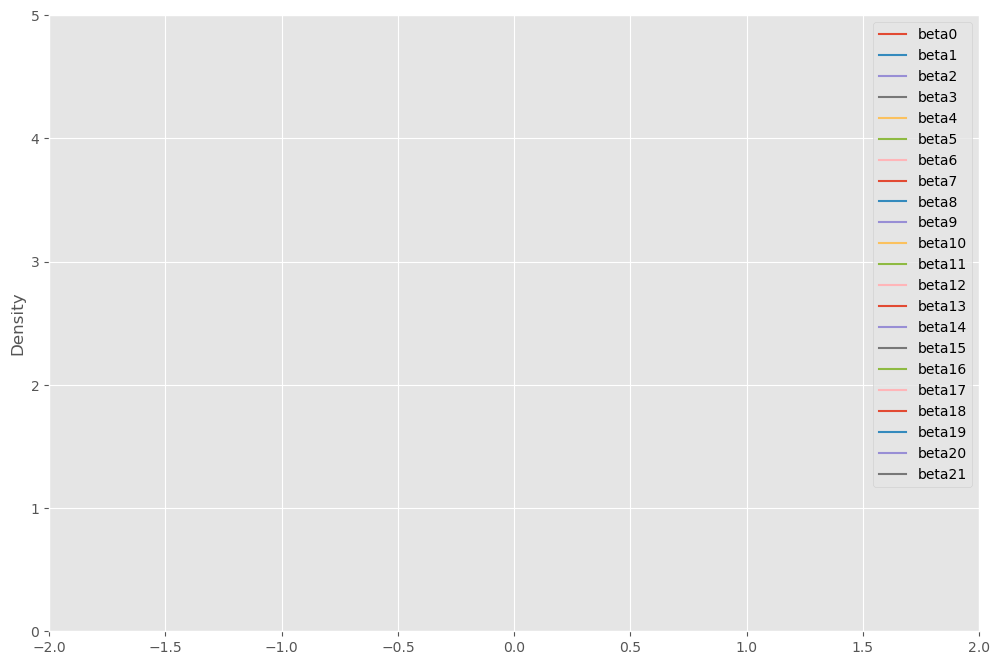

In [38]:
for i in range(x_train_clean.shape[1]):
    sns.kdeplot(posterior_samples["beta"][:,i])

    # Alternative to avoid warnings
    #sns.histplot(posterior_samples["beta"][:,i], kde=True, color=next(palette), stat='density', element='step')

plt.legend(["beta%d" % i for i in range(x_train_clean.shape[1])])
plt.axis([-2,2,0,5])
plt.show()

In [18]:
def pred(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Normal(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [19]:
def pred_gamma(x, post_samples):
    return pyro.sample('prediction',pyro.distributions.Gamma(post_samples['mu'].mean(dim=0)[x],post_samples['sigma'].mean(dim=0)[x]))

In [20]:
posterior_samples = mcmc.get_samples()

In [21]:
posterior_samples['mu'].mean(dim=0)[1], posterior_samples['sigma'].mean(dim=0)[1]

(tensor(3.7327), tensor(0.0006))

In [22]:
business = pyro.distributions.Gamma(torch.tensor(14.3093), torch.tensor(0.0003)).sample_n(74938,)
economy = pyro.distributions.Gamma(torch.tensor(3.7298), torch.tensor(0.0006)).sample_n(165184,)

C:\Users\jhegu\anaconda3\lib\site-packages\torch\distributions\distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jhegu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


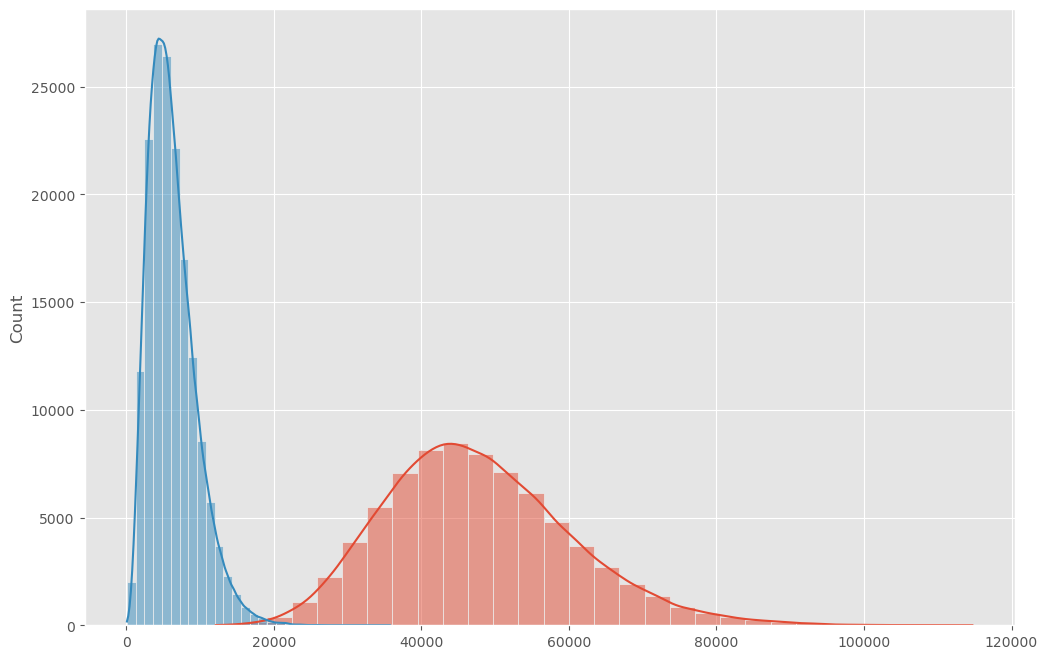

In [23]:
sns.histplot(business, bins=30, kde=True)
sns.histplot(economy, bins=30, kde=True)

plt.show()

In [24]:
pred_gamma([0,1],posterior_samples), pred_gamma([0,1],posterior_samples)

(tensor([60013.9727,  6433.2676]), tensor([70395.4375,  5395.3462]))

In [25]:
posterior_samples['mu'][0]
posterior_samples['sigma'][0]

tensor([0.0003, 0.0006])

In [26]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [27]:
pred_gamma(1,posterior_samples)

tensor(7478.2378)

In [28]:
pred_y = pred_gamma(x_test_clean, posterior_samples)

corr, mae, rae, rmse, r2 = compute_error(y_test_clean.numpy(),pred_y.numpy())

print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
#type(pred_y.numpy()), type(y_test_clean.numpy())

CorrCoef: 0.874
MAE: 7290.943
RMSE: 11427.566
R2: 0.745
